# Data Preparation

In [1]:
import warnings
warnings.filterwarnings("ignore")

import pandas as pd
import datetime

import statsmodels.formula.api as sm
from sklearn.preprocessing import MinMaxScaler

import util_functions as uf

# Get Data

In [2]:
today = datetime.datetime.now()
end_date = datetime.datetime(today.year, today.month, today.day)
start_date = datetime.datetime(today.year-1, 1, 1)

In [3]:
df = uf.getdata('GOOG',[20, 50],'Close', start_date, end_date)

[*********************100%%**********************]  1 of 1 completed


# Remove NA

In [4]:
df = df.dropna(subset=df.columns.tolist())

In [5]:
df['next_day_close'] = df['Close'].shift(-1)

In [6]:
df = df.dropna(subset=['next_day_close'])

In [7]:
df = df.drop(columns='ticker')

# Remove Outliers

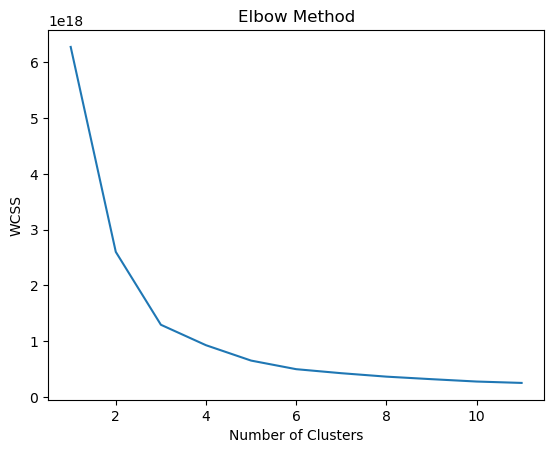

In [8]:
plot_k_clusters = uf.kmeans_elbow_method(df.drop(columns=['Date']))

In [9]:
df_outliers = uf.detect_outliers_kmeans(df.drop(columns='Date'), 4)

Number of outliers = 38


In [10]:
# Check for location of outliers
df[df.index.isin(df_outliers.index.tolist())][['Date','next_day_close']].groupby(pd.Grouper(key='Date', freq='M')).count()

,next_day_close
Date,
2023-03-31,4
2023-04-30,0
2023-05-31,12
2023-06-30,1
2023-07-31,1
2023-08-31,4
2023-09-30,6
2023-10-31,0
2023-11-30,0


In [11]:
df = df[~df.index.isin(df_outliers.index.tolist())]

# Scale df

In [12]:
df_x = df.drop(columns=['Date','next_day_close'])
df_y = df[['next_day_close']]

In [13]:
scaler_x = MinMaxScaler()
scaler_y = MinMaxScaler()

In [14]:
df_scaled_x, df_scaled_y = uf.df_min_max_scaler(df_x, df_y, scaler_x, scaler_y)

# PCA - reduce dimensionality

In [15]:
df_scaled_x.columns

Index(['Open', 'High', 'Low', 'Close', 'Volume', 'sma_20', 'ema_20', 'wma_20',
       'sma_50', 'ema_50', 'wma_50', 'upper_band', 'middle_band', 'Lower_band',
       'bb_width', 'bb_percent', 'obv', 'vwap', 'adl', 'adx', 'macd',
       'ichimoku_a', 'ichimoku_b', 'rsi', 'stoch', 'cci', 'roc', 'atr', 'kc',
       'uo', 'wr', 'doji', 'hammer', 'engulfing', 'harami'],
      dtype='object')

In [36]:
df_pca_full_x = uf.apply_PCA(df_scaled_x)

# df

In [37]:
df = pd.concat([df_pca_full_x, df_scaled_y], axis=1)

# Feature engineering

In [39]:
# Calculate the correlation coefficients between market indicators and stock prices
correlation_matrix = df.corr()
correlation_with_stock_prices = correlation_matrix['next_day_close'].dropna()
relevant_indicators = correlation_with_stock_prices[abs(correlation_with_stock_prices) > 0.5].index.tolist()

# Identify relevant indicators

In [40]:
relevant_indicators

['PCA0', 'next_day_close']

In [41]:
relevant_indicators = df.columns

# Train Model

In [42]:
# Check for NaN values
nan_locations = df.isna().any()

# Get the columns with NaN values
columns_with_nan = nan_locations[nan_locations].index.tolist()

# Get the rows with NaN values
rows_with_nan = df[df.isna().any(axis=1)].index.tolist()


In [43]:
df = df.fillna(0)

# Check for overfitting

In [44]:
import warnings
warnings.filterwarnings("ignore")

from statsmodels.tsa.arima.model import ARIMA
from sklearn.metrics import mean_squared_error

# Set the window size and step size for cross-validation
window_size = 100
step_size = 10

for i in relevant_indicators[:-1]:

    mse_scores_test = []
    mse_scores_train = []
    
    df_temp = df[relevant_indicators].drop(columns=i)    
    # Perform rolling window cross-validation
    for start in range(0, len(df) - window_size + 1, step_size):
        
        end = start + window_size
        
        # Split the data into training and validation sets
        train_data = df_temp.iloc[start:end]
        test_data = df_temp.iloc[end:end+step_size]

        train_data_endog = train_data['next_day_close']
        train_data_exog = train_data.drop(columns='next_day_close')

        test_data_endog = test_data['next_day_close']
        test_data_exog = test_data.drop(columns='next_day_close')
        
        # Fit the ARIMAX model
        model = ARIMA(endog=train_data_endog, exog=train_data_exog, order=(0, 0, 0))
        model_fit = model.fit()

        # Make predictions
        test_predictions = model_fit.get_forecast(steps=len(test_data), exog=test_data_exog)
        train_predictions = model_fit.get_forecast(steps=len(train_data), exog=train_data_exog)

        val_predictions_mean = test_predictions.predicted_mean
        val_predictions_mean = val_predictions_mean.values.reshape(-1,1)
        test_pred = scaler_y.inverse_transform(val_predictions_mean)

        test_endo = test_data_endog.values.reshape(-1,1)
        test_endo = scaler_y.inverse_transform(test_endo)

        train_predictions_mean = train_predictions.predicted_mean
        train_pred = train_predictions_mean.values.reshape(-1,1)
        train_pred = scaler_y.inverse_transform(train_pred)

        train_endo = train_data_endog.values.reshape(-1,1)
        train_endo = scaler_y.inverse_transform(train_endo)

        #Calculate mean squared error (MSE) as the performance metric
        mse_test = mean_squared_error(test_endo, test_pred)
        mse_scores_test.append(round(mse_test,4))

        mse_train = mean_squared_error(train_endo, train_pred)
        mse_scores_train.append(round(mse_train,4))

    print("Remove {} = {}\n{}".format(i,mse_scores_test,mse_scores_train))

Remove PCA0 = [45.9388, 193.8899, 75.2537, 91.7263, 15.2215, 67.322, 41.6978, 11.1585, 57.1823, 16.0172, 10.1961, 6.5446]
[25.7597, 24.5166, 26.9757, 24.3177, 17.8419, 16.9331, 18.9538, 7.934, 5.66, 7.2542, 8.0753, 8.1479]
Remove PCA1 = [13.0668, 25.0954, 159.9055, 20.753, 50.0347, 14.5827, 14.3824, 4.252, 31.8513, 6.4798, 39.4345, 12.775]
[8.2073, 8.8011, 9.7316, 18.5791, 15.8733, 19.0626, 17.433, 12.406, 8.872, 9.9225, 10.0543, 10.6683]
Remove PCA2 = [3.5815, 5.0967, 42.2253, 2.7582, 2.4369, 6.9006, 8.8974, 11.7747, 31.0502, 9.7043, 22.5804, 10.6816]
[3.6634, 3.5997, 3.5424, 5.9356, 5.7182, 5.1964, 5.0832, 4.9247, 5.5847, 6.4232, 6.3756, 7.1472]
Remove PCA3 = [3.7217, 5.2626, 38.3747, 5.7686, 2.6163, 6.7075, 3.4835, 6.3218, 39.6223, 7.3817, 16.7414, 10.2991]
[3.6494, 3.6153, 3.554, 5.5514, 5.222, 4.9913, 5.2466, 4.4929, 4.6032, 5.851, 5.784, 6.307]
Remove PCA4 = [3.434, 4.9365, 39.3552, 1.9292, 1.3229, 7.462, 2.8433, 4.692, 26.6249, 4.3801, 17.177, 9.2248]
[3.6731, 3.6026, 3.5401, 5.

In [45]:
#df = df[relevant_indicators].drop(columns='Close')

# Find Best Order

In [46]:
train_size = int(len(df) * 0.8)  # 80% for training
train_data = df[:train_size]
test_data = df[train_size:]

# ARIMA Model Prediction

In [47]:
uf.find_best_order_accuracy(train_data, test_data, df_y, train_size, scaler_y)

Accuracy of best order (2,1,2) = 0.6744186046511628


# SARIMA Model

In [29]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error


# Specify the order and seasonal order of the SARIMA model
order = (2, 0, 0)  # (p, d, q)
seasonal_order = (1, 0, 0, 90)  # (P, D, Q, seasonal_periods)

# Create the SARIMA model
model = SARIMAX(endog=train_data_endog, exog=train_data_exog, order=order, seasonal_order=seasonal_order)

# Fit the SARIMA model
results = model.fit()

# Forecast on the test data
forecast = results.get_forecast(steps=len(test_data), exog=test_data_exog)

# Get the predicted mean values
predicted_values = forecast.predicted_mean
val_predictions_mean = predicted_values.values.reshape(-1,1)
test_pred = scaler_y.inverse_transform(val_predictions_mean)
test_pred_series = pd.Series(test_pred.flatten())

# Calculate the price change from the predicted values
predicted_price_change = test_pred_series.diff()

# Create a binary target variable indicating if the price change is positive (1) or not (0)
predicted_price_up = (predicted_price_change > 0).astype(int)

# Calculate the actual price change from the test data
actual_price_change = test_data['next_day_close'].diff()

# Create a binary target variable for the actual price change
actual_price_up = (actual_price_change > 0).astype(int)

# Calculate the accuracy of the predictions
accuracy = accuracy_score(actual_price_up, predicted_price_up)

# Print the accuracy
print(f"Accuracy: {accuracy}")

Accuracy: 0.5
